In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import warnings # supress warnings
warnings.filterwarnings('ignore')

# Pré-processamento

In [2]:
df_integrado = pd.read_csv('df-final.csv', encoding='utf-8', sep='\t')
df_integrado['sentimento'] = df_integrado['sentimento'].apply(lambda x: x if pd.isna(x) else x[:-1])
df_integrado = df_integrado.drop(columns=['Unnamed: 0', 'selo','prox_taxa', 'val_taxa', 'etapa_1', 'etapa_2'])
df_integrado.drop(columns=['pessoa1', 'pessoa2', 'parcela', 'rodada', 'jogo', 'saldo_AgCD1', 'saldo_AgCD2', 'saldo_AgCD3', 'saldo_AgAT1', 'saldo_AgAT2', 'saldo_AgAT3', 'saldo_EmpAgro', 'saldo_EmpFert', 'saldo_EmpMaq', 'saldo_EmpSem', 'saldo_FiscalAT', 'saldo_FiscalCD', 'saldo_PrefeitoAT', 'saldo_PrefeitoCD'], inplace = True)
df_integrado.head()

,acao,objeto,tipo_preco,poluicao_mundial,tratamento,sentimento
0,venda,Soja,normal,20.33,NaN,nojo
1,venda,Premium,normal,21.85,NaN,tristeza
2,venda,Super premium,normal,24.56,NaN,alegria
3,venda,Soja,normal,24.89,NaN,nojo
4,venda,Premium,normal,26.41,NaN,tristeza


In [3]:
df_integrado = pd.concat([df_integrado,pd.get_dummies(df_integrado[['acao','objeto','tipo_preco','tratamento', 'sentimento']], drop_first = True)], axis=1)

df_integrado.drop(columns=['acao','objeto','tipo_preco','tratamento', 'sentimento'], axis = 1, inplace = True)
#df_integrado['parcela'].fillna(value=0, inplace=True)
df_integrado.head()

,poluicao_mundial,acao_imposto,acao_multa,acao_selo,acao_transferencia,acao_tratamento,acao_troca taxa,acao_venda,objeto_Comum,objeto_Hortalica,...,objeto_Soja,objeto_Super premium,tipo_preco_baixo,tipo_preco_normal,tratamento_Esgoto,tratamento_Lixo,sentimento_medo,sentimento_nojo,sentimento_raiva,sentimento_tristeza
0,20.33,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,21.85,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,24.56,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
3,24.89,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
4,26.41,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [4]:
scaler = MinMaxScaler()

numeric_vars = ['poluicao_mundial']
df_integrado[numeric_vars] = scaler.fit_transform(df_integrado[numeric_vars])
df_integrado.head()

,poluicao_mundial,acao_imposto,acao_multa,acao_selo,acao_transferencia,acao_tratamento,acao_troca taxa,acao_venda,objeto_Comum,objeto_Hortalica,...,objeto_Soja,objeto_Super premium,tipo_preco_baixo,tipo_preco_normal,tratamento_Esgoto,tratamento_Lixo,sentimento_medo,sentimento_nojo,sentimento_raiva,sentimento_tristeza
0,0.000585,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0.004623,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.011823,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0.012700,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
4,0.016738,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [5]:
# train-test 70-30 split
df_train, df_test = train_test_split(df_integrado, train_size = 0.7, test_size = 0.3, random_state = 100)

y_train = df_train.pop('poluicao_mundial')
X_train = df_train

y_test = df_test.pop('poluicao_mundial')
X_test = df_test

In [6]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores

array([0.02053562, 0.11597822, 0.12732066, 0.10652095, 0.0127071 ])

# Modelos

In [7]:
def sorteia_df(df, num):
    df_index = list(df.index)
    indexs = np.random.choice(df_index,num)
    new_df = df.iloc[indexs]
    return new_df

Regressão Linear

In [8]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [9]:
print('Linear Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("R2: " + str(r2))

Linear Regression
Mean absolute error: 0.17224082188413548
Mean squared error: 0.04509542293790564
R2: 0.09998795390030646


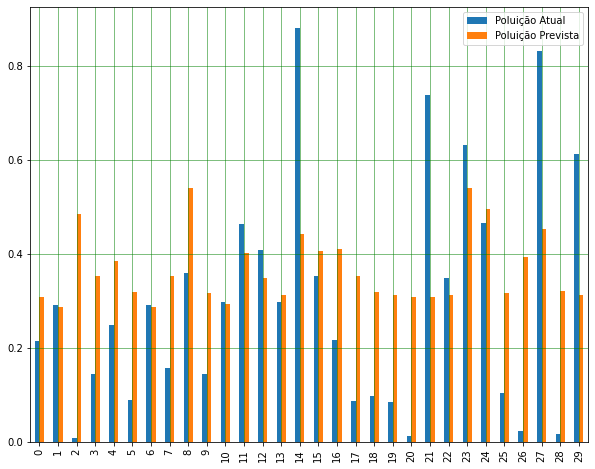

In [10]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 30)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_lm_barras.png')

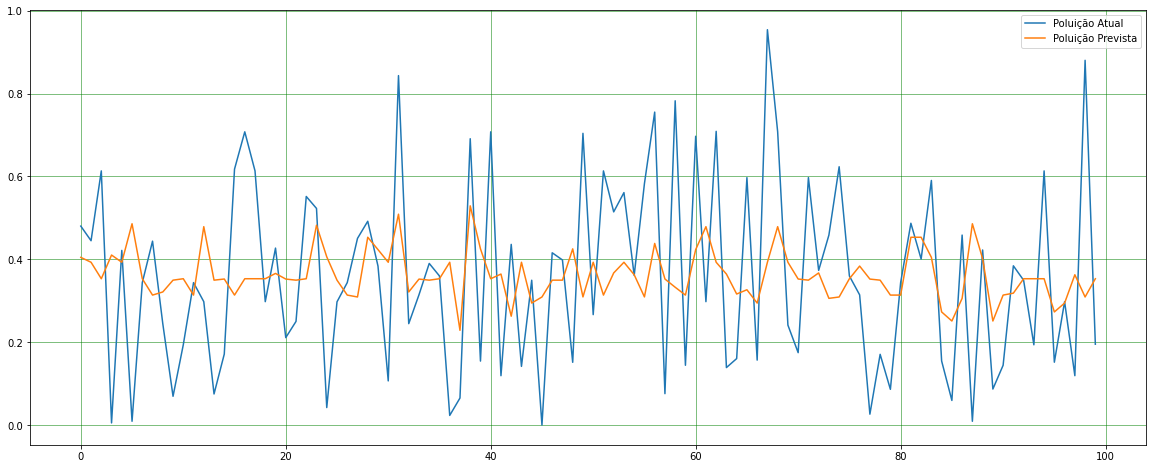

In [11]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 100)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='line',figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_lm_linhas.png')

Decision Tree Regressor

In [12]:
DTR = DecisionTreeRegressor(random_state = 0)
DTR.fit(X_train, y_train)

y_pred = DTR.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [13]:
print('Decision Tree Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("R2: " + str(r2))

Decision Tree Regression
Mean absolute error: 0.1556388815366783
Mean squared error: 0.039955847108858675
R2: 0.20256333420784756


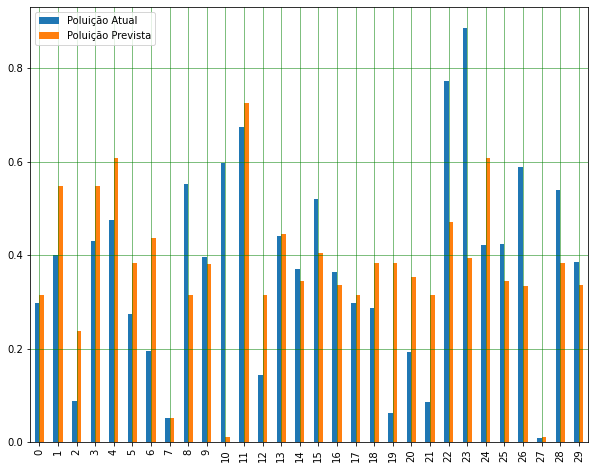

In [14]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 30)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_dtr_barras.png')

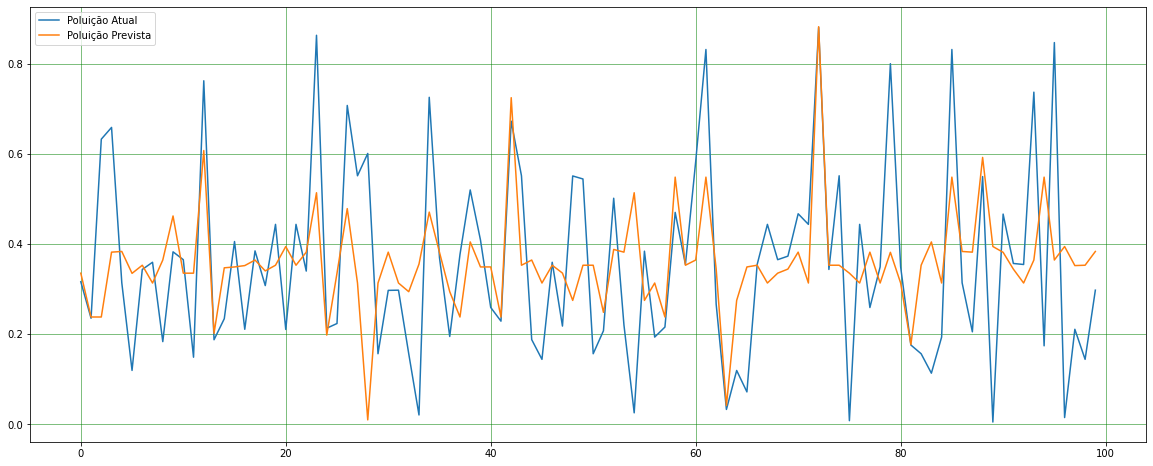

In [15]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 100)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='line',figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_dtr_linhas.png')

Random Forest Regressor

In [16]:
RFR = RandomForestRegressor(n_estimators = 100)
RFR.fit(X_train, y_train)

y_pred = RFR.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [17]:
print('Random Forest Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("R2: " + str(r2))

Random Forest Regression
Mean absolute error: 0.15692708998339505
Mean squared error: 0.04011601596253605
R2: 0.19936669276780372


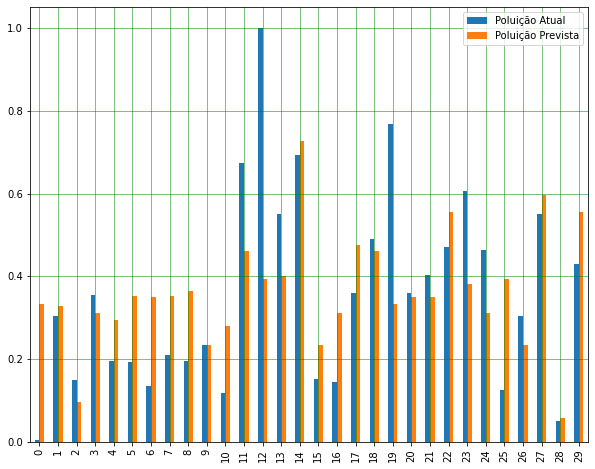

In [18]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 30)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_rfr_barras.png')

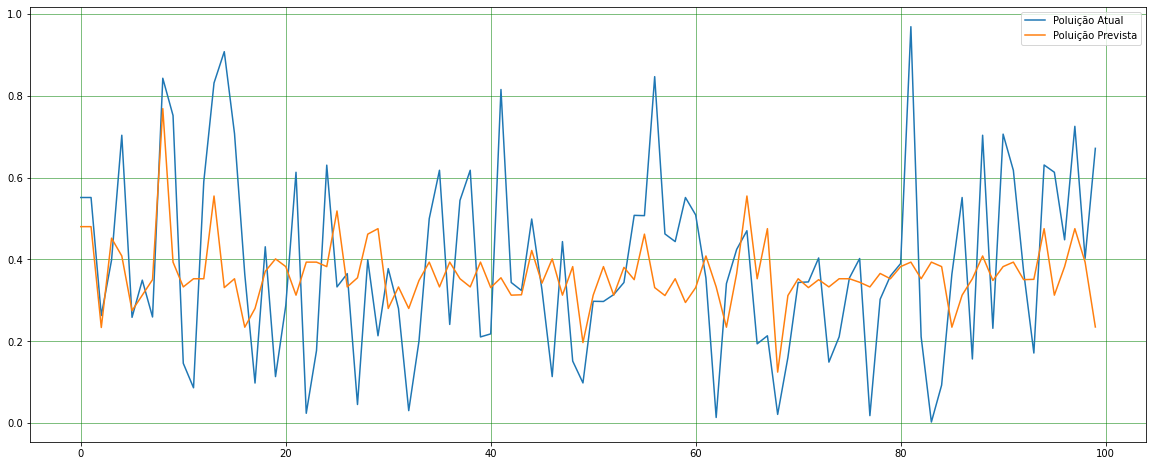

In [19]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 100)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='line',figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_rfr_linhas.png')

Support Vector Regression

In [20]:
SVR = SVR(kernel = 'rbf')
SVR.fit(X_train, y_train)

y_pred = SVR.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [21]:
print('SVR Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("R2: " + str(r2))

SVR Regression
Mean absolute error: 0.16263680207597767
Mean squared error: 0.04188326791041641
R2: 0.16409597263783426


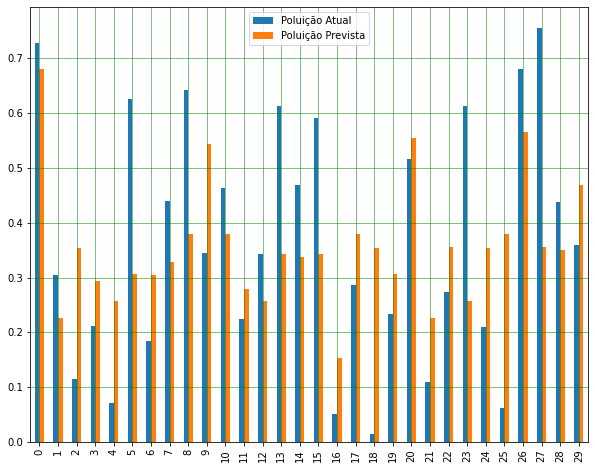

In [22]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 30)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_svr_barras.png')

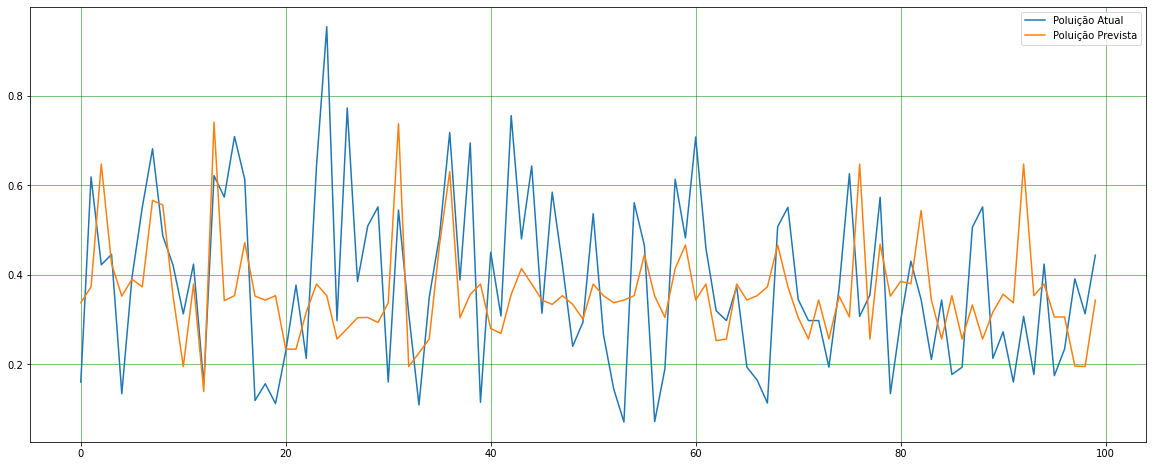

In [23]:
df = pd.DataFrame({'Poluição Atual': y_test, 'Poluição Prevista': y_pred})
df.reset_index(drop=True, inplace=True)
df1 = sorteia_df(df, 100)
df1.reset_index(drop=True, inplace=True)
df1.plot(kind='line',figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()
plt.savefig('grafico_svr_linhas.png')